Podstawowy kod to klasyfikacji obrazów z wykorzystaniem sieci konwolucyjnych.
Zachęcamy do odkomentowania dwóch zakomentowanych linii kodu i zastanowienia się jak one wpływają na trening.

Import pakietów

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Ustawienie ziarna losowości

In [35]:
def set_seed(seed):
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

Ustawienie wartości hiperparametrów

In [36]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001
patience = 3  # Early stopping patience

Przygotowanie danych

In [37]:
transform_train = transforms.Compose([
    #transforms.RandomHorizontalFlip(),  # jest to przykład zastosowania data augmentation - stosuje się tylko do zbioru treningowego
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# zbiór danych CIFAR-10
full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# utworzenie zbiorów treningowego, walidacyjnego i testowego
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Funkcja do wizualizacji danych

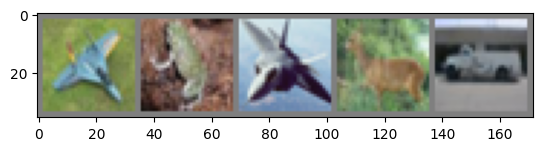

plane frog  plane deer  truck


In [38]:
# functions to show an image
num_samples=5
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images=images[:num_samples]
labels=labels[:num_samples]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(num_samples)))
#source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Zdefiniowanie architektury modelu

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)  # jest stosowany w celu regularyzacji sieci
        x = self.fc2(x)
        return x

Funkcja do treningu sieci neuronowej w ramach jednej epoki

In [40]:
def train():
    model.train()
    total_loss = 0
    total= 0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f'Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


Funkcja do wykonania inferencji w ramach ewaluacji modelu

In [41]:
def inference(data_loader, split):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    print(f'{split} Loss: {avg_loss:.4f}, {split} Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

# Funkcje train() i inference() mogłyby zostać zintegrowane w celu uproszczenia kodu,
# jednak dla zachowania czytelności i łatwiejszego zrozumienia podjęto decyzję o ich rozdzieleniu.

Trenining sieci neuronowej z mechanizmem early stopping

In [42]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# Early stopping variables
best_val_loss = float('inf')
stopping_steps = 0

# Metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss, train_acc = train()
    val_loss, val_acc = inference(val_loader, 'Validation')


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        stopping_steps = 0
        torch.save(model.state_dict(), 'best_cifar10_cnn.pth')
        print('Model improved and saved as best_cifar10_cnn.pth')
    else:
        stopping_steps += 1
        print(f'Early stopping counter: {stopping_steps}/{patience}')
        if stopping_steps >= patience:
            print('Early stopping triggered')
            break

Epoch 1/10
Training Loss: 1.4069, Training Accuracy: 49.62%
Validation Loss: 1.1643, Validation Accuracy: 58.93%
Model improved and saved as best_cifar10_cnn.pth
Epoch 2/10
Training Loss: 1.0396, Training Accuracy: 63.23%
Validation Loss: 0.9999, Validation Accuracy: 64.32%
Model improved and saved as best_cifar10_cnn.pth
Epoch 3/10
Training Loss: 0.8710, Training Accuracy: 68.98%
Validation Loss: 0.9190, Validation Accuracy: 67.43%
Model improved and saved as best_cifar10_cnn.pth
Epoch 4/10
Training Loss: 0.7586, Training Accuracy: 73.39%
Validation Loss: 0.8615, Validation Accuracy: 69.68%
Model improved and saved as best_cifar10_cnn.pth
Epoch 5/10
Training Loss: 0.6557, Training Accuracy: 77.00%
Validation Loss: 0.8820, Validation Accuracy: 69.46%
Early stopping counter: 1/3
Epoch 6/10
Training Loss: 0.5635, Training Accuracy: 79.98%
Validation Loss: 0.8638, Validation Accuracy: 70.62%
Early stopping counter: 2/3
Epoch 7/10
Training Loss: 0.4822, Training Accuracy: 83.13%
Validation

Wizualizacja procesu treningu

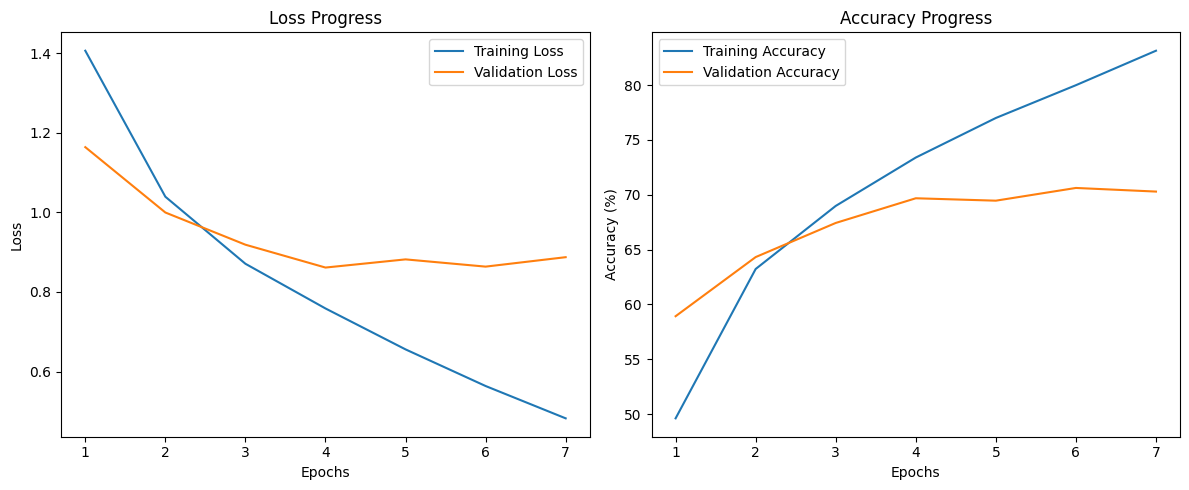

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Progress')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Progress')
plt.legend()

plt.tight_layout()
plt.show()


Ewaluacja modelu na danych testowych

In [44]:
model.load_state_dict(torch.load('best_cifar10_cnn.pth'))
inference(test_loader, 'Test');

<ipython-input-44-3a6429dcd5b0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cifar10_cnn.pth'))


Test Loss: 0.8716, Test Accuracy: 69.84%
